In [ ]:
import os
import torch
from glob import glob
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import timm
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import kagglehub

## Configuration

In [ ]:
class Config:
    model_name = "efficientnet_b3"
    img_size = 300
    batch_size = 32
    lr = 5e-5
    epochs = 50
    patience = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_split = 0.70
    val_split = 0.15
    test_split = 0.15
    experiments = {
        "with_sampler": True,
        "without_sampler": False,
    }

    save_dir = "checkpoints"
    os.makedirs(save_dir, exist_ok=True)

CFG = Config()

## Transform & Dataset Class

In [ ]:
train_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

class ChestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# Google Colab training
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
DATA_DIR = f"{path}/chest_xray/"

# Local training
# DATA_DIR = "Dataset/chest_xray/"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")

normal_imgs = glob(TEST_DIR + "/NORMAL/*.jpeg") + glob(TRAIN_DIR + "/NORMAL/*.jpeg") + glob(VAL_DIR + "/NORMAL/*.jpeg")
pneumonia_imgs = glob(TEST_DIR + "/PNEUMONIA/*.jpeg") + glob(TRAIN_DIR + "/PNEUMONIA/*.jpeg") + glob(VAL_DIR + "/PNEUMONIA/*.jpeg")

all_images = normal_imgs + pneumonia_imgs
labels = [0]*len(normal_imgs) + [1]*len(pneumonia_imgs)

print(f"Total normal images: {len(normal_imgs)}")
print(f"Total pneumonia images: {len(pneumonia_imgs)}")

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Total normal images: 1583
Total pneumonia images: 4273


In [ ]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    all_images, labels, test_size=CFG.test_split, stratify=labels, random_state=42
)

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    train_imgs, train_labels, test_size=CFG.val_split/(1-CFG.val_split), stratify=train_labels, random_state=42
)

print("Train:", len(train_imgs))
print("Val:", len(val_imgs))
print("Test:", len(test_imgs))

Train: 4098
Val: 879
Test: 879


## DataLoaders with WeightedRandomSampler

In [ ]:
# Build loaders with or without a weighted sampler to compare class balancing strategies
def build_loaders(use_sampler: bool):
    class_counts = [train_labels.count(0), train_labels.count(1)]  # Normal, Pneumonia
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

    sample_weights = [class_weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(
        sample_weights, num_samples=len(sample_weights), replacement=True
    ) if use_sampler else None

    train_data = ChestDataset(train_imgs, train_labels, transform=train_tf)
    val_data   = ChestDataset(val_imgs, val_labels, transform=test_tf)
    test_data  = ChestDataset(test_imgs, test_labels, transform=test_tf)

    train_loader = DataLoader(
        train_data, batch_size=CFG.batch_size, sampler=sampler, shuffle=not use_sampler
    )
    val_loader   = DataLoader(val_data, batch_size=CFG.batch_size, shuffle=False)
    test_loader  = DataLoader(test_data, batch_size=CFG.batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, class_weights

## EfficientNet-B3 Model

In [ ]:
def build_model(class_weights):
    model = timm.create_model(
        CFG.model_name,
        pretrained=True,
        num_classes=2
    ).to(CFG.device)

    # Freeze every parameter first for stability
    for p in model.parameters():
        p.requires_grad = False

    # Unfreeze final conv + bn if available
    if hasattr(model, 'conv_head'):
        for p in model.conv_head.parameters():
            p.requires_grad = True

    # Replace classifier head for our task (2 classes) with better regularization
    in_features = model.get_classifier().in_features
    model.classifier = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Dropout(p=0.15),
        nn.Linear(in_features, 2)
    ).to(CFG.device)

    for p in model.classifier.parameters():
        p.requires_grad = True

    # Freeze all BatchNorm layers in EfficientNet backbone (keep classifier trainable)
    for name, m in model.named_modules():
        if name.startswith('classifier'):
            continue
        if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d, nn.SyncBatchNorm)):
            m.eval()
            for param in m.parameters():
                param.requires_grad = False

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(CFG.device))
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=CFG.lr, weight_decay=1e-5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5
    )

    return model, criterion, optimizer, scheduler

## Training Model

In [ ]:
def set_bn_eval(module):
    if isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d, nn.SyncBatchNorm)):
        module.eval()


def train_epoch(model, loader, criterion, optimizer):
    model.train()
    # Keep BatchNorm layers frozen during training
    model.apply(set_bn_eval)
    total_loss, correct = 0.0, 0

    for imgs, labels in tqdm(loader, desc="Train", leave=False, total=len(loader)):
        imgs = imgs.to(CFG.device)
        labels = torch.as_tensor(labels, dtype=torch.long, device=CFG.device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss/len(loader), correct/len(loader.dataset)


def validate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False, total=len(loader)):
            imgs = imgs.to(CFG.device)
            labels = torch.as_tensor(labels, dtype=torch.long, device=CFG.device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss/len(loader), correct/len(loader.dataset)


def run_experiment(label: str, use_sampler: bool):
    train_loader, val_loader, _, class_weights = build_loaders(use_sampler)
    model, criterion, optimizer, scheduler = build_model(class_weights)

    best_val_loss = np.inf
    patience_counter = 0
    best_model_path = f"{CFG.save_dir}/{label}_best.pt"

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc" : []
    }

    for epoch in range(CFG.epochs):
        print(f"\n[{label}] Epoch {epoch+1}/{CFG.epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f}  |  Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}  |  Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(">>> Saved best model!")
        else:
            patience_counter += 1
            if patience_counter >= CFG.patience:
                print(">>> Early stopping triggered!")
                break

    return history, best_model_path


histories = {}
best_paths = {}

for name, use_sampler in CFG.experiments.items():
    print(f"\n=== Running {name} (use_sampler={use_sampler}) ===")
    history, best_path = run_experiment(name, use_sampler)
    histories[name] = history
    best_paths[name] = best_path


=== Running with_sampler (use_sampler=True) ===

[with_sampler] Epoch 1/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.3749  |  Acc: 0.7138
Val   Loss: 0.3483  |  Acc: 0.8305
>>> Saved best model!

[with_sampler] Epoch 2/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2046  |  Acc: 0.8917
Val   Loss: 0.2736  |  Acc: 0.8658
>>> Saved best model!

[with_sampler] Epoch 3/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1679  |  Acc: 0.9104
Val   Loss: 0.2628  |  Acc: 0.8680
>>> Saved best model!

[with_sampler] Epoch 4/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1615  |  Acc: 0.9143
Val   Loss: 0.2269  |  Acc: 0.8908
>>> Saved best model!

[with_sampler] Epoch 5/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1613  |  Acc: 0.9134
Val   Loss: 0.2171  |  Acc: 0.8965
>>> Saved best model!

[with_sampler] Epoch 6/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1408  |  Acc: 0.9317
Val   Loss: 0.2035  |  Acc: 0.9090
>>> Saved best model!

[with_sampler] Epoch 7/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1384  |  Acc: 0.9339
Val   Loss: 0.2061  |  Acc: 0.9101

[with_sampler] Epoch 8/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1290  |  Acc: 0.9358
Val   Loss: 0.2419  |  Acc: 0.8885

[with_sampler] Epoch 9/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1148  |  Acc: 0.9400
Val   Loss: 0.2135  |  Acc: 0.9056

[with_sampler] Epoch 10/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1166  |  Acc: 0.9409
Val   Loss: 0.1742  |  Acc: 0.9249
>>> Saved best model!

[with_sampler] Epoch 11/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1257  |  Acc: 0.9449
Val   Loss: 0.1896  |  Acc: 0.9215

[with_sampler] Epoch 12/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1135  |  Acc: 0.9451
Val   Loss: 0.1736  |  Acc: 0.9261
>>> Saved best model!

[with_sampler] Epoch 13/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1060  |  Acc: 0.9510
Val   Loss: 0.1969  |  Acc: 0.9170

[with_sampler] Epoch 14/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1167  |  Acc: 0.9441
Val   Loss: 0.1688  |  Acc: 0.9306
>>> Saved best model!

[with_sampler] Epoch 15/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0922  |  Acc: 0.9551
Val   Loss: 0.1670  |  Acc: 0.9317
>>> Saved best model!

[with_sampler] Epoch 16/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0995  |  Acc: 0.9544
Val   Loss: 0.1623  |  Acc: 0.9306
>>> Saved best model!

[with_sampler] Epoch 17/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0959  |  Acc: 0.9519
Val   Loss: 0.1563  |  Acc: 0.9340
>>> Saved best model!

[with_sampler] Epoch 18/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0896  |  Acc: 0.9546
Val   Loss: 0.1760  |  Acc: 0.9249

[with_sampler] Epoch 19/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0923  |  Acc: 0.9544
Val   Loss: 0.1782  |  Acc: 0.9204

[with_sampler] Epoch 20/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0843  |  Acc: 0.9614
Val   Loss: 0.2064  |  Acc: 0.9067

[with_sampler] Epoch 21/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0910  |  Acc: 0.9558
Val   Loss: 0.1686  |  Acc: 0.9249

[with_sampler] Epoch 22/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0915  |  Acc: 0.9539
Val   Loss: 0.1600  |  Acc: 0.9329
>>> Early stopping triggered!

=== Running without_sampler (use_sampler=False) ===

[without_sampler] Epoch 1/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.4285  |  Acc: 0.8785
Val   Loss: 0.2953  |  Acc: 0.8692
>>> Saved best model!

[without_sampler] Epoch 2/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.2395  |  Acc: 0.9056
Val   Loss: 0.2371  |  Acc: 0.8874
>>> Saved best model!

[without_sampler] Epoch 3/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1965  |  Acc: 0.9197
Val   Loss: 0.2128  |  Acc: 0.9113
>>> Saved best model!

[without_sampler] Epoch 4/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1794  |  Acc: 0.9292
Val   Loss: 0.1990  |  Acc: 0.9215
>>> Saved best model!

[without_sampler] Epoch 5/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1723  |  Acc: 0.9375
Val   Loss: 0.1897  |  Acc: 0.9283
>>> Saved best model!

[without_sampler] Epoch 6/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1567  |  Acc: 0.9402
Val   Loss: 0.1930  |  Acc: 0.9204

[without_sampler] Epoch 7/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1567  |  Acc: 0.9419
Val   Loss: 0.1762  |  Acc: 0.9374
>>> Saved best model!

[without_sampler] Epoch 8/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1470  |  Acc: 0.9446
Val   Loss: 0.1731  |  Acc: 0.9397
>>> Saved best model!

[without_sampler] Epoch 9/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1412  |  Acc: 0.9488
Val   Loss: 0.1670  |  Acc: 0.9386
>>> Saved best model!

[without_sampler] Epoch 10/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1351  |  Acc: 0.9485
Val   Loss: 0.1637  |  Acc: 0.9386
>>> Saved best model!

[without_sampler] Epoch 11/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1266  |  Acc: 0.9544
Val   Loss: 0.1608  |  Acc: 0.9386
>>> Saved best model!

[without_sampler] Epoch 12/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1352  |  Acc: 0.9519
Val   Loss: 0.1575  |  Acc: 0.9408
>>> Saved best model!

[without_sampler] Epoch 13/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1381  |  Acc: 0.9558
Val   Loss: 0.1555  |  Acc: 0.9363
>>> Saved best model!

[without_sampler] Epoch 14/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1232  |  Acc: 0.9568
Val   Loss: 0.1552  |  Acc: 0.9363
>>> Saved best model!

[without_sampler] Epoch 15/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1217  |  Acc: 0.9561
Val   Loss: 0.1551  |  Acc: 0.9329
>>> Saved best model!

[without_sampler] Epoch 16/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1192  |  Acc: 0.9580
Val   Loss: 0.1511  |  Acc: 0.9363
>>> Saved best model!

[without_sampler] Epoch 17/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1152  |  Acc: 0.9573
Val   Loss: 0.1452  |  Acc: 0.9431
>>> Saved best model!

[without_sampler] Epoch 18/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1125  |  Acc: 0.9571
Val   Loss: 0.1454  |  Acc: 0.9386

[without_sampler] Epoch 19/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1179  |  Acc: 0.9614
Val   Loss: 0.1456  |  Acc: 0.9386

[without_sampler] Epoch 20/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1144  |  Acc: 0.9622
Val   Loss: 0.1403  |  Acc: 0.9477
>>> Saved best model!

[without_sampler] Epoch 21/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1075  |  Acc: 0.9614
Val   Loss: 0.1422  |  Acc: 0.9397

[without_sampler] Epoch 22/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1090  |  Acc: 0.9605
Val   Loss: 0.1400  |  Acc: 0.9420
>>> Saved best model!

[without_sampler] Epoch 23/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1175  |  Acc: 0.9636
Val   Loss: 0.1364  |  Acc: 0.9431
>>> Saved best model!

[without_sampler] Epoch 24/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0997  |  Acc: 0.9644
Val   Loss: 0.1375  |  Acc: 0.9431

[without_sampler] Epoch 25/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1011  |  Acc: 0.9622
Val   Loss: 0.1381  |  Acc: 0.9408

[without_sampler] Epoch 26/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0989  |  Acc: 0.9622
Val   Loss: 0.1324  |  Acc: 0.9556
>>> Saved best model!

[without_sampler] Epoch 27/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0985  |  Acc: 0.9649
Val   Loss: 0.1306  |  Acc: 0.9499
>>> Saved best model!

[without_sampler] Epoch 28/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.1001  |  Acc: 0.9632
Val   Loss: 0.1329  |  Acc: 0.9465

[without_sampler] Epoch 29/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0958  |  Acc: 0.9671
Val   Loss: 0.1334  |  Acc: 0.9420

[without_sampler] Epoch 30/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0926  |  Acc: 0.9680
Val   Loss: 0.1304  |  Acc: 0.9454
>>> Saved best model!

[without_sampler] Epoch 31/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0917  |  Acc: 0.9658
Val   Loss: 0.1300  |  Acc: 0.9465
>>> Saved best model!

[without_sampler] Epoch 32/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0923  |  Acc: 0.9712
Val   Loss: 0.1288  |  Acc: 0.9477
>>> Saved best model!

[without_sampler] Epoch 33/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0878  |  Acc: 0.9707
Val   Loss: 0.1267  |  Acc: 0.9522
>>> Saved best model!

[without_sampler] Epoch 34/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0878  |  Acc: 0.9695
Val   Loss: 0.1252  |  Acc: 0.9556
>>> Saved best model!

[without_sampler] Epoch 35/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0903  |  Acc: 0.9714
Val   Loss: 0.1316  |  Acc: 0.9443

[without_sampler] Epoch 36/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0885  |  Acc: 0.9688
Val   Loss: 0.1231  |  Acc: 0.9545
>>> Saved best model!

[without_sampler] Epoch 37/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0890  |  Acc: 0.9697
Val   Loss: 0.1316  |  Acc: 0.9443

[without_sampler] Epoch 38/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0774  |  Acc: 0.9729
Val   Loss: 0.1222  |  Acc: 0.9568
>>> Saved best model!

[without_sampler] Epoch 39/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0813  |  Acc: 0.9702
Val   Loss: 0.1282  |  Acc: 0.9488

[without_sampler] Epoch 40/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0797  |  Acc: 0.9714
Val   Loss: 0.1221  |  Acc: 0.9534
>>> Saved best model!

[without_sampler] Epoch 41/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0817  |  Acc: 0.9702
Val   Loss: 0.1270  |  Acc: 0.9477

[without_sampler] Epoch 42/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0808  |  Acc: 0.9693
Val   Loss: 0.1206  |  Acc: 0.9568
>>> Saved best model!

[without_sampler] Epoch 43/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0780  |  Acc: 0.9727
Val   Loss: 0.1217  |  Acc: 0.9545

[without_sampler] Epoch 44/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0795  |  Acc: 0.9719
Val   Loss: 0.1204  |  Acc: 0.9602
>>> Saved best model!

[without_sampler] Epoch 45/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0801  |  Acc: 0.9746
Val   Loss: 0.1229  |  Acc: 0.9556

[without_sampler] Epoch 46/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0776  |  Acc: 0.9761
Val   Loss: 0.1270  |  Acc: 0.9488

[without_sampler] Epoch 47/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0756  |  Acc: 0.9739
Val   Loss: 0.1208  |  Acc: 0.9556

[without_sampler] Epoch 48/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0725  |  Acc: 0.9754
Val   Loss: 0.1188  |  Acc: 0.9568
>>> Saved best model!

[without_sampler] Epoch 49/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0742  |  Acc: 0.9744
Val   Loss: 0.1184  |  Acc: 0.9590
>>> Saved best model!

[without_sampler] Epoch 50/50


Train:   0%|          | 0/129 [00:00<?, ?it/s]

Val:   0%|          | 0/28 [00:00<?, ?it/s]

Train Loss: 0.0676  |  Acc: 0.9766
Val   Loss: 0.1162  |  Acc: 0.9590
>>> Saved best model!


## Plot Loss & Training Curves

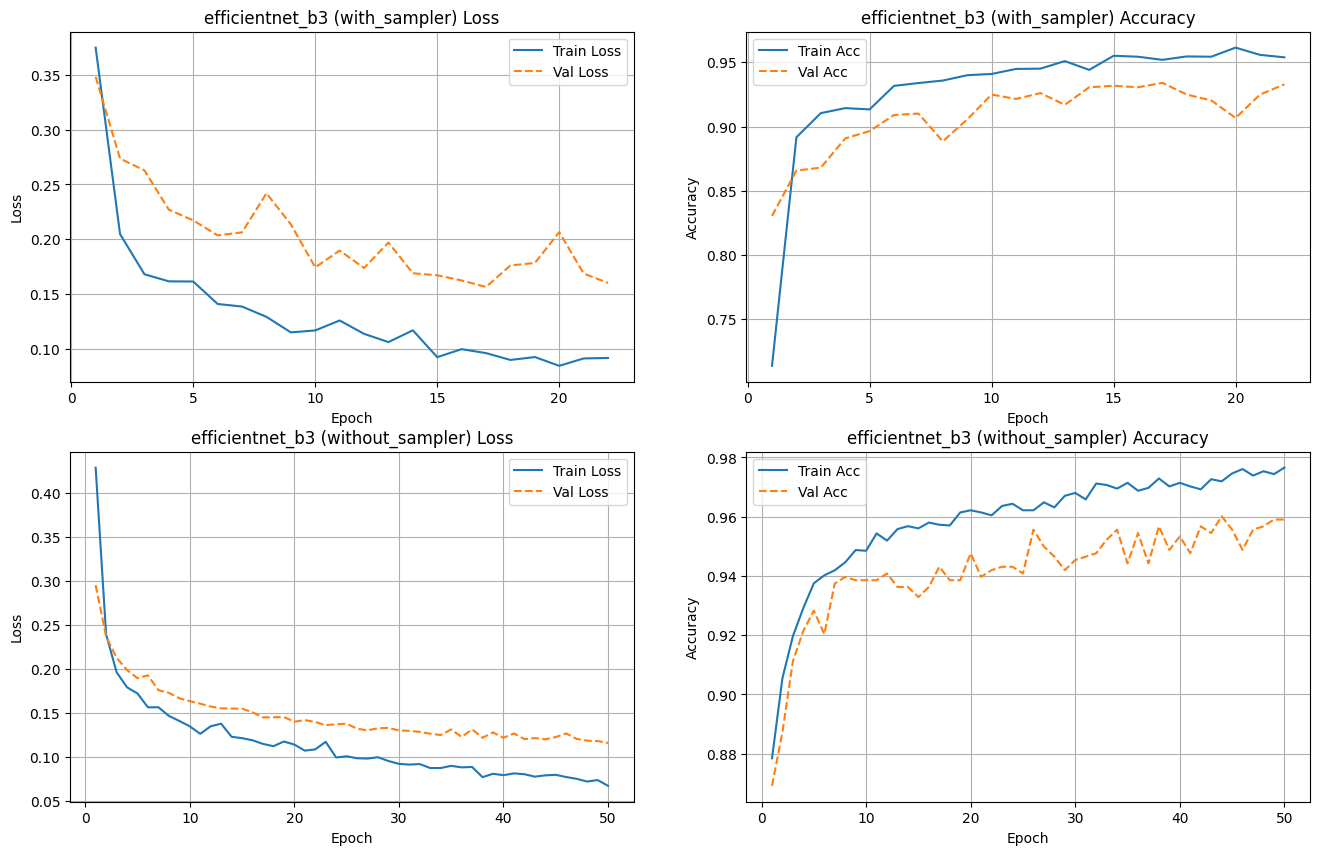

In [ ]:
plt.figure(figsize=(16, 10))

# with_sampler loss/acc
if "with_sampler" in histories:
    hs = histories["with_sampler"]
    epochs_range = range(1, len(hs["train_loss"]) + 1)

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, hs["train_loss"], label="Train Loss")
    plt.plot(epochs_range, hs["val_loss"], linestyle="--", label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{CFG.model_name} (with_sampler) Loss")
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, hs["train_acc"], label="Train Acc")
    plt.plot(epochs_range, hs["val_acc"], linestyle="--", label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{CFG.model_name} (with_sampler) Accuracy")
    plt.legend()
    plt.grid()

# without_sampler loss/acc
if "without_sampler" in histories:
    hs = histories["without_sampler"]
    epochs_range = range(1, len(hs["train_loss"]) + 1)

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, hs["train_loss"], label="Train Loss")
    plt.plot(epochs_range, hs["val_loss"], linestyle="--", label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{CFG.model_name} (without_sampler) Loss")
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, hs["train_acc"], label="Train Acc")
    plt.plot(epochs_range, hs["val_acc"], linestyle="--", label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{CFG.model_name} (without_sampler) Accuracy")
    plt.legend()
    plt.grid()

plt.show()

## Model Evaluation

In [ ]:
def evaluate_model(best_path: str, use_sampler: bool):
    _, _, test_loader, class_weights = build_loaders(use_sampler)
    model, _, _, _ = build_model(class_weights)
    model.load_state_dict(torch.load(best_path, map_location=CFG.device))
    model.to(CFG.device)
    model.eval()

    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(CFG.device)
            outputs = model(imgs)
            preds = outputs.argmax(1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
            probs_batch = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs_batch)

    return {"preds": all_preds, "labels": all_labels, "probs": all_probs}


eval_results = {}
for name, use_sampler in CFG.experiments.items():
    print(f"Evaluating {name} (use_sampler={use_sampler})")
    eval_results[name] = evaluate_model(best_paths[name], use_sampler)
    print(f"{name}: collected {len(eval_results[name]['labels'])} test samples")

Evaluating with_sampler (use_sampler=True)
with_sampler: collected 879 test samples
Evaluating without_sampler (use_sampler=False)
without_sampler: collected 879 test samples


## Confusion Matrix + Classification Report + ROC-AUC

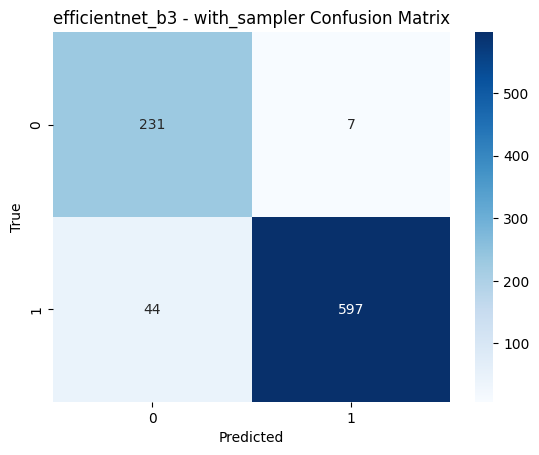

efficientnet_b3 - with_sampler classification report
              precision    recall  f1-score   support

      Normal       0.84      0.97      0.90       238
   Pneumonia       0.99      0.93      0.96       641

    accuracy                           0.94       879
   macro avg       0.91      0.95      0.93       879
weighted avg       0.95      0.94      0.94       879



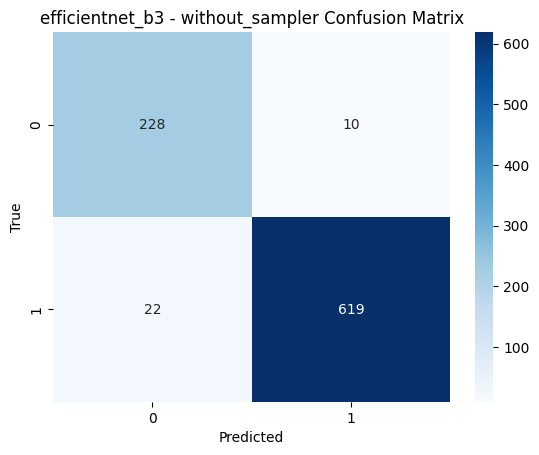

efficientnet_b3 - without_sampler classification report
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       238
   Pneumonia       0.98      0.97      0.97       641

    accuracy                           0.96       879
   macro avg       0.95      0.96      0.95       879
weighted avg       0.96      0.96      0.96       879



In [ ]:
for name, result in eval_results.items():
    cm = confusion_matrix(result["labels"], result["preds"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{CFG.model_name} - {name} Confusion Matrix")
    plt.show()

    print(f"{CFG.model_name} - {name} classification report")
    print(classification_report(result["labels"], result["preds"], target_names=["Normal", "Pneumonia"]))

with_sampler ROC AUC Score: 0.9937


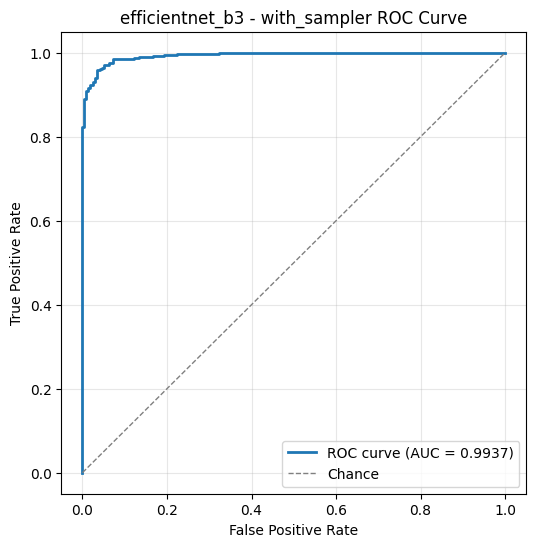

without_sampler ROC AUC Score: 0.9953


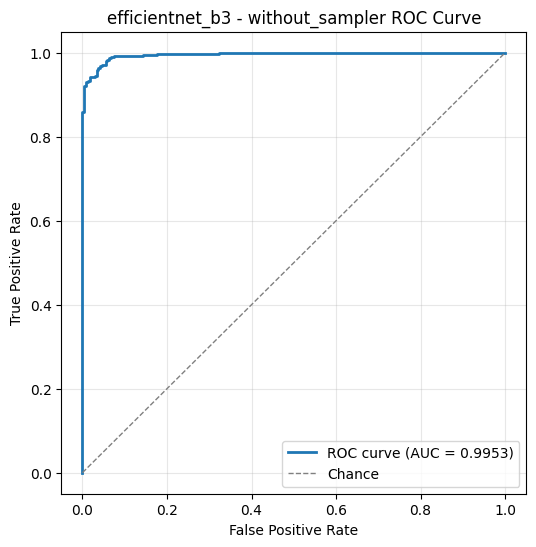

In [ ]:
for name, result in eval_results.items():
    fpr, tpr, _ = roc_curve(result["labels"], result["probs"], pos_label=1)
    auc_score = roc_auc_score(result["labels"], result["probs"])

    print(f"{name} ROC AUC Score: {auc_score:.4f}")

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color="C0", lw=2, label=f"ROC curve (AUC = {auc_score:.4f})")
    plt.plot([0,1], [0,1], color="gray", lw=1, linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{CFG.model_name} - {name} ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()